# Multiple Logistic Regression

Logistic regression is named for the function used at the core of the method, the logistic function. Logistic regression uses an equation as the representation, very much like linear regression. Input values (X) are combined linearly using weights or coefficient values to predict an output value (y). A key difference from linear regression is that the output value being modeled is a binary value (0 or 1) rather than a numeric value. 

Each column in your input data has an associated b coefficient (a constant real value) that must be learned from your training data. The actual representation of the model that you would store in memory or in a file are the coefficients in the equation (the beta value or b’s). The coefficients of the logistic regression algorithm must be estimated from your training data using **stochastic gradient descent**.

Gradient Descent is the process of minimizing a function by following the gradients of the cost function. This involves knowing the form of the cost as well as the derivative so that from a given point you know the gradient and can move in that direction, e.g. downhill towards the minimum value.

In machine learning, we can use a technique that evaluates and updates the coefficients every iteration called stochastic gradient descent to minimize the error of a model on our training data. The way this optimization algorithm works is that each training instance is shown to the model one at a time. The model makes a prediction for a training instance, the error is calculated and the model is updated in order to reduce the error for the next prediction. This process is repeated for a fixed number of iterations.

## Exercise 1 - Explore the Data

After we develop our logistic regression algorithm with stochastic gradient descent, we will use it to model the Pima Indians diabetes dataset. This dataset involves predicting the onset of diabetes within 5 years in Pima Indians given basic medical details. It is a binary classification problem, where the prediction is either 0 (no diabetes) or 1 (diabetes). It contains 768 rows and 9 columns. All of the values in the file are numeric, specifically floating point values. You can learn more about the dataset on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes).

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [3]:
pima = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data")

In [10]:
#1. Number of times pregnant
#2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
#3. Diastolic blood pressure (mm Hg)
#4. Triceps skin fold thickness (mm)
#5. 2-Hour serum insulin (mu U/ml)
#6. Body mass index (weight in kg/(height in m)^2)
#7. Diabetes pedigree function
#8. Age (years)
#9. Class variable (0 or 1)

col_names = ('times pregnant','glucose','blood pressure','skin thickness','insulin', 'bmi','Diabetes pedigree', 'Age')

print(pima.info())
pima.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
6        767 non-null int64
148      767 non-null int64
72       767 non-null int64
35       767 non-null int64
0        767 non-null int64
33.6     767 non-null float64
0.627    767 non-null float64
50       767 non-null int64
1        767 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.0 KB
None


,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


In [23]:
pima.columns = ['times_pregnant','glucose','blood_pressure','skin_thickness','insulin', 'bmi','Diabetes_pedigree', 'Age', 'Class']

In [15]:
pima.corr()

,times pregnant,glucose,blood pressure,skin thickness,insulin,bmi,Diabetes pedigree,Age,Class
times pregnant,1.000000,0.128846,0.141197,-0.082495,-0.072999,0.017518,-0.033927,0.544018,0.221087
glucose,0.128846,1.000000,0.152498,0.056381,0.332383,0.220955,0.136903,0.262408,0.465856
blood pressure,0.141197,0.152498,1.000000,0.207308,0.089098,0.281777,0.041180,0.239571,0.064882
skin thickness,-0.082495,0.056381,0.207308,1.000000,0.437974,0.392553,0.183498,-0.115873,0.073265
insulin,-0.072999,0.332383,0.089098,0.437974,1.000000,0.198111,0.185579,-0.040942,0.131984
bmi,0.017518,0.220955,0.281777,0.392553,0.198111,1.000000,0.140546,0.035911,0.292695
Diabetes pedigree,-0.033927,0.136903,0.041180,0.183498,0.185579,0.140546,1.000000,0.032738,0.173245
Age,0.544018,0.262408,0.239571,-0.115873,-0.040942,0.035911,0.032738,1.000000,0.236417
Class,0.221087,0.465856,0.064882,0.073265,0.131984,0.292695,0.173245,0.236417,1.000000


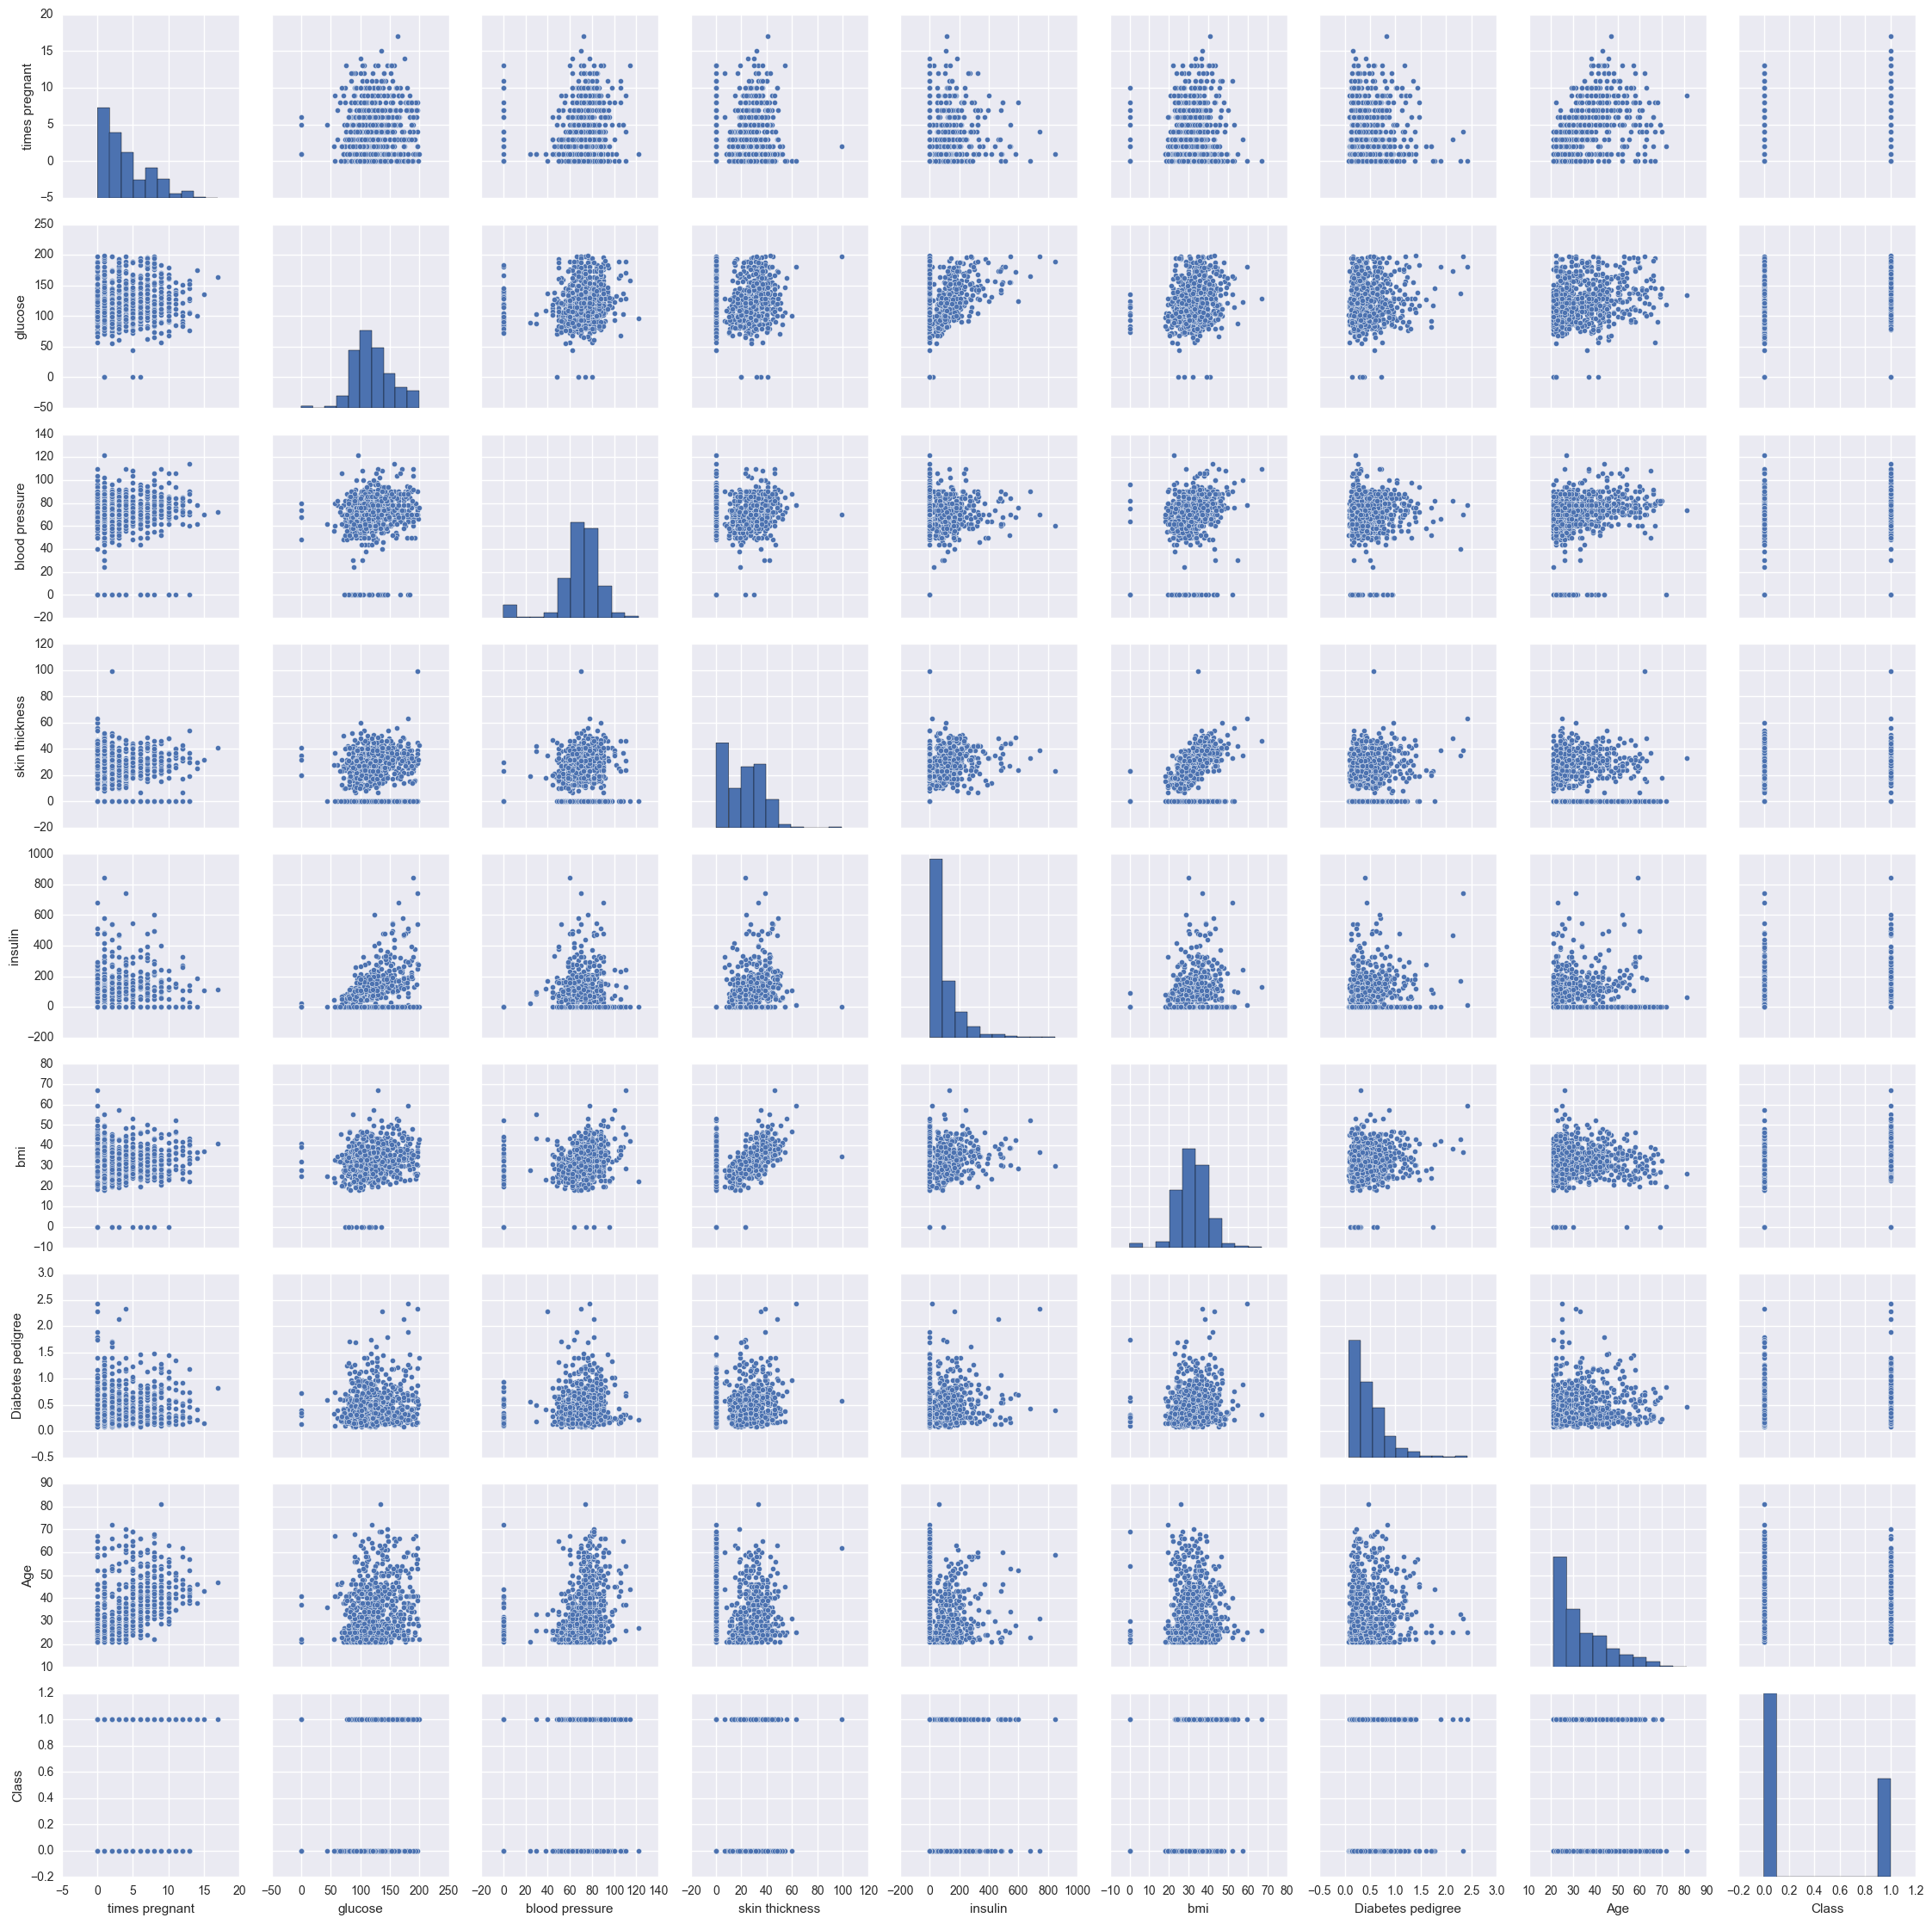

In [16]:
import seaborn as sns
sns.pairplot(pima)

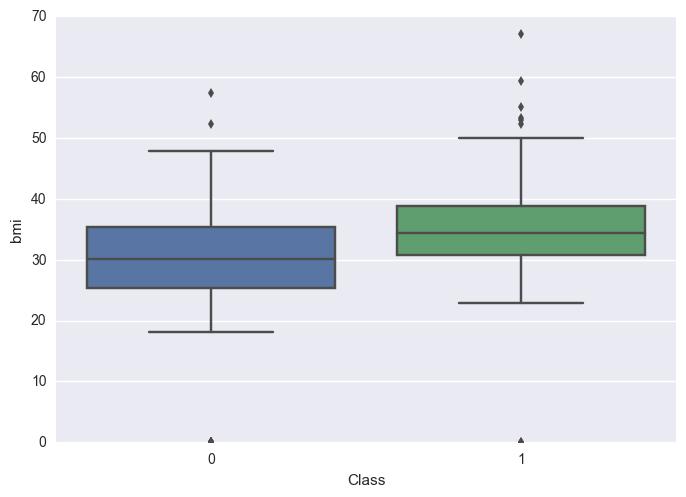

In [17]:
sns.boxplot(pima['Class'], pima['bmi'])

## Exercise 2 - Build a Multiple Logistic Regression Class

We will be using the [generalized linear model implementation](https://en.wikipedia.org/wiki/Logistic_regression#As_a_generalized_linear_model). Here is a nice visual explanation of [stochastic gradient descent](https://spin.atomicobject.com/2014/06/24/gradient-descent-linear-regression/). 

The general steps are:
- Estimate coefficient values for the training data using stochastic gradient descent
- Evaluation candidate coeffeicient values 
- Tune learning rate and number of epochs
- Make predictions on out-of-sample data

The class should do the following:
- Fit a set of X (health data) and y (diabetes binary value)
- Return the coefficients and intercept
- Predict new X based on the coefficients (round to 0 or 1)
- Return accuracy score

In [62]:
from math import e

def h(x, theta):
    return 1.0/(1.0+e**(np.dot(x, -theta)))

def sgd(x,y, a=.001, ep=.001, max_iter= 10000):
    cvg= False
    m=0
    n=x.shape[0]
    
    theta= np.random.random(x.shape[1])
    p=np.arange(x.shape[0])
    te = sum([(y[i]- h(x[i], theta)) **2 for i in range(n)])
    
    while not cvg:
        p= np.random.permutation(p)
        
        for i in p:
            z= (y[i]- h(x[i], theta)) *x[i]
            theta = theta +a *z
            e = sum([(y[i]- h(x[i], theta)) **2 for i in range(n)])
        
        if abs(te-e) <= ep:
            print("Converged, iterations: ", m)
            cfg= True
            
        te= e
        m+=1        
        
        if m == max_iter:
            print("Max Iterations Exceeded")
        cvg= True
        
    return theta           

In [63]:
from sklearn.preprocessing import scale
features = scale(pima.values[:,:8])
features = np.array([np.append(1, i) for i in features])
y = pima.values[:, 8]

train = features[:features.shape[0]//2]
Y_train = y[:y.shape[0]//2]
test = features[features.shape[0]//2:]
Y_test = y[y.shape[0]//2:]

In [65]:
theta = sgd(train, Y_train)

In [67]:
results = np.round([h(i, theta) for i in test])

In [74]:
def accuracy_metric(actual, predicted):

    correct = 0
    
    for i in range(len(actual)):
        if actual[i]== predicted[i]:
            correct +=1
        
    return correct / float(len(actual)) *100     

In [75]:
baseline = np.random.randint(2, size =len(Y_test))
accuracy_metric(Y_test, baseline)

52.34375

In [76]:
# Could have benefited by using more factors
accuracy_metric(Y_test, results)

57.291666666666664

## Exercise 3 - Try it out on the Pima Indians Diabetes Data Set

In [ ]:
# see above

## Exercise 4 - Check via Statsmodels or Scikit-learn

In [83]:
import statsmodels.api as sm

# Model with select predictors
import statsmodels.api as sm
formula = 'Class ~ times_pregnant + glucose + blood_pressure+insulin+bmi+Diabetes_pedigree+Age'
model = smf.glm(formula=formula, data=pima)
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Class   No. Observations:                  767
Model:                            GLM   Df Residuals:                      759
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                  0.160008749516
Method:                          IRLS   Log-Likelihood:                -381.53
Date:                Tue, 14 Mar 2017   Deviance:                       121.45
Time:                        10:53:26   Pearson chi2:                     121.
No. Iterations:                     4                                         
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept            -0.8513      0.085     -9.959      0.000        -1.019    -0.684
times_pregnant        0.0206   

In [84]:
theta

array([ 0.74817928,  0.41649838,  0.57287115,  0.01362062,  0.38453492,
        0.13115984,  0.60212006,  0.02450998,  0.10121291])

In [ ]:
print("Coeffieients")
print(result.params)
print
print("p-Values")
print(result.pvalues)
print
print("Dependent variables")
print(result.model.endog_names)

# Additional Optional Exercises

- Proper documentation for class methods and attributes
- Build with NumPy methods and compare computation time
- Change the stochastic gradient descent to employ batch learning 
- [Other varieties](https://tminka.github.io/papers/logreg/index.html) of logistic regression